# Paper replication

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch

from collections import Counter
from copy import deepcopy
from IPython.display import clear_output
from scipy.stats import entropy
from tqdm import tqdm

from ca_funcs import get_network_entropies, make_table_walk, make_ca, make_glider
from train_ca import initialize_model
from utils import all_combinations

from nni.compression.torch import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
M = 2
D = (3, 3)
ALL_INPUTS = all_combinations(M, D)
RANDOM_INPUTS = np.random.choice([0, 1], (500, 10, 10))

## Define CAs and training data

In [3]:
def sample_CAs(seed=None):
    if seed:
        np.random.seed(seed)

    inputs = ALL_INPUTS
    outputs = make_table_walk(len(ALL_INPUTS))
    for o in outputs:
        yield make_ca(inputs, o)

def generate_CA_train_data(ca, height=10, width=10, n_samples=500):
    X_train = torch.from_numpy(np.random.choice([0, 1], (n_samples, height, width), p=[.5, .5])).float()
    Y_train = ca(X_train).float()
    return X_train, Y_train

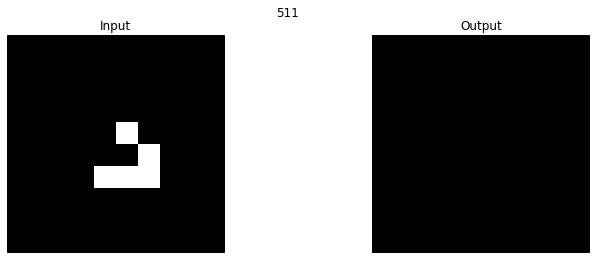

In [4]:
np.random.seed(0)

for i, ca in enumerate(sample_CAs()):
    X_test = torch.from_numpy(make_glider(10).reshape(1, 10, 10)).float()
    Y_test = ca(X_test).float()

    plt.figure(figsize=(12,4))
    plt.suptitle(i)

    plt.subplot(1,2,1)
    plt.imshow(X_test[0])
    plt.axis('off')
    plt.title("Input")

    plt.subplot(1,2,2)
    plt.imshow(Y_test[0])
    plt.axis('off')
    plt.title("Output")

    plt.show()
    plt.close()
    clear_output(wait=True)

## Find entropy of the training CA

In [5]:
def ca_entropy(ca):        
    inputs = torch.from_numpy(ALL_INPUTS)
    outputs = ca(inputs)
    output_counts = np.array(list(Counter(tuple(torch.reshape(o, [-1]).numpy()) for o in outputs).values()))
    output_ps = output_counts / len(inputs)
    return entropy(output_ps, base=2)

512it [00:13, 38.68it/s]


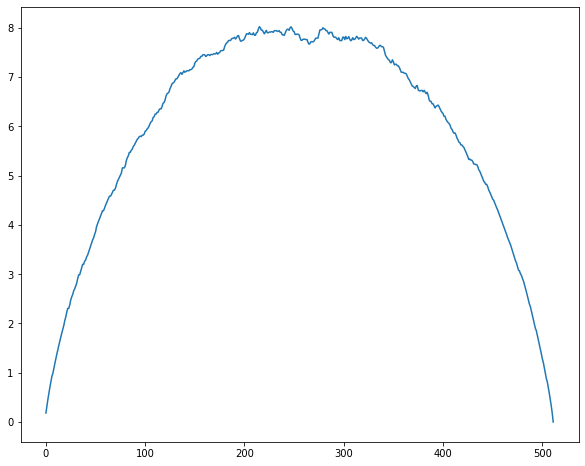

In [6]:
entropies = [ca_entropy(a) for a in tqdm(sample_CAs(seed=0))]
plt.plot(entropies)

## Define the model

In [7]:
seed = 0
print('seed =', seed)

np.random.seed(seed)
torch.random.manual_seed(seed)

num_classes = 2
samples = 500
input_dims = [10, 10]
layer_dims = [100] + [100] * 11  # neighborhood conv + mlpconv layers
batch_size = 10
num_batches = samples // batch_size
learning_rate = 1e-4
training_epochs = 60  # 1500
display_step = int(training_epochs / 10)
loss = torch.nn.MSELoss()

model = initialize_model(input_dims, layer_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

if torch.cuda.is_available():
    model.cuda()

seed = 0
Sequential(
  (Wraparound2D): Wraparound2D()
  (Conv2d_0): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1))
  (ReLU_0): ReLU()
  (Conv2d_1): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_1): ReLU()
  (Conv2d_2): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_2): ReLU()
  (Conv2d_3): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_3): ReLU()
  (Conv2d_4): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_4): ReLU()
  (Conv2d_5): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_5): ReLU()
  (Conv2d_6): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_6): ReLU()
  (Conv2d_7): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_7): ReLU()
  (Conv2d_8): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_8): ReLU()
  (Conv2d_9): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_9): ReLU()
  (Conv2d_10): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (ReLU_10): ReLU()
  (Conv2d_1

## Define the learning loop

In [8]:
losses = []

def learn_CA(ca, model, optimizer, training_epochs):
    losses = []
    X_train, Y_train = generate_CA_train_data(ca, *input_dims, n_samples=samples)
    if torch.cuda.is_available():
        X_train = X_train.cuda()
        Y_train = Y_train.cuda()

    for _ in tqdm(range(training_epochs)):
        batch_losses = []
        for i in range(num_batches):
            X_batch = X_train[i * batch_size : (i + 1) * batch_size]
            Y_batch = Y_train[i * batch_size : (i + 1) * batch_size]

            optimizer.zero_grad()
            Y_pred = model(X_batch)
            l = loss(Y_batch, Y_pred)
            l.backward()
            optimizer.step()
            batch_losses.append(l.item())
        losses.append(np.mean(batch_losses))
    return losses

## Train the model

In [9]:
ca = list(sample_CAs(seed=0))[250]
losses = learn_CA(ca, model, optimizer, training_epochs)

100%|██████████| 60/60 [01:31<00:00,  1.52s/it]


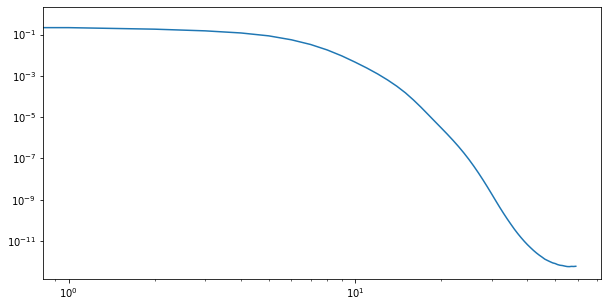

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.loglog();

max loss: 2.7578222e-12


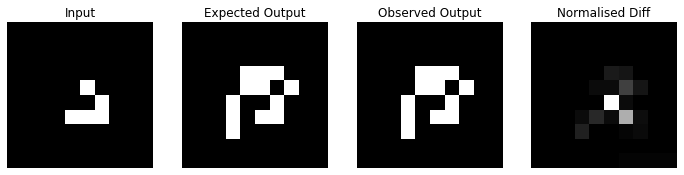

In [11]:
# x = np.random.choice([0, 1], size=100)
x = make_glider(10)
X_test = torch.from_numpy(x.reshape(1, 10, 10)).float()
Y_test = ca(X_test).float()

if torch.cuda.is_available():
    X_test = X_test.cuda()
Y_pred = model(X_test)


if torch.cuda.is_available():
    X_test = X_test.cpu()
    Y_pred = Y_pred.cpu()

X_test = X_test.detach().numpy()
Y_test = Y_test.detach().numpy()
Y_pred = Y_pred.detach().numpy()

plt.figure(figsize=(12, 4))

plt.subplot(141)
plt.imshow(X_test[0])
plt.axis('off')
plt.title("Input")

plt.subplot(142)
plt.imshow(Y_test[0])
plt.axis('off')
plt.title("Expected Output")

plt.subplot(143)
plt.imshow(Y_pred[0])
plt.axis('off')
plt.title("Observed Output")

plt.subplot(144)
plt.imshow((Y_pred[0] - Y_test[0]) ** 2)
plt.axis('off')
plt.title("Normalised Diff")

print('max loss:', ((Y_pred[0] - Y_test[0]) ** 2).max())

## Find model entropies

In [12]:
def calculate_entropies(model):
    def get_activations(x_input):
        activations = []
        for m in model.children():
            x_input = m(x_input)
            activations.append(x_input)
        return activations[1:-3:2]

    X_test = np.pad(all_combinations(2, (3, 3)), [(0, 0), (3, 4), (3, 4)], 'wrap')
    X_test = torch.from_numpy(X_test).float()
        
    if torch.cuda.is_available():
        X_test = X_test.cuda()

    res = [activation.cpu().detach().numpy() for activation in get_activations(X_test)]
    layer_activations = np.array(res)
    # Layer activations are floats, but to calculate entropy,
    # we want to map activations to binary values,
    # 1 if a given activation is >0, and 0 otherwise.
    binary_activations = np.digitize(layer_activations, [0], right=True)
    binary_activations = binary_activations.transpose(0, 1, -2, -1, 2) \
        .reshape(len(layer_dims), np.product(X_test.shape), layer_dims[0])
    return get_network_entropies(binary_activations)

In [13]:
ca_entropy(ca)

8.220523247971135

In [14]:
calculate_entropies(model)

(8.79856952502345,
 [8.79856952502345,
  8.79856952502345,
  8.79856952502345,
  8.79856952502345,
  8.79856952502345,
  8.784795087512633,
  8.787625915645744,
  8.79856952502345,
  8.787472224325226,
  8.777295087512632,
  8.795125915645746,
  8.79856952502345],
 [array([0.67733486, 0.95978857, 0.91364415, 0.8654699 , 0.94473883,
         0.96233685, 0.96946939, 0.61295961, 0.82768804, 0.86300251,
         0.53115474, 0.821994  , 0.68551568, 0.37518466, 0.99620509,
         1.        , 0.64320574, 0.98259956, 0.57930721, 0.74858985,
         0.98478007, 0.34698129, 0.64320574, 0.99988729, 0.5776539 ,
         0.49041745, 0.81521654, 0.99986362, 0.92836207, 0.302118  ,
         0.44062845, 0.99447011, 0.89245069, 0.91746025, 0.73303643,
         0.72936499, 0.14840256, 0.91235172, 0.26200376, 0.79607809,
         0.27297086, 0.21587865, 0.21887773, 0.20062232, 0.99184127,
         0.97274928, 0.65339755, 0.87033048, 0.76130709, 0.44062845,
         0.95304136, 0.53472659, 0.26476503, 

## Compression

In [15]:
def prune_model_and_test(model, Pruner, config):
    model_copy = deepcopy(model)
    pruner = Pruner(model_copy, config, optimizer=optimizer)
    pruner.compress()
    return model_copy

def display_test(model):
    x = make_glider(10)
    X_test = torch.from_numpy(x.reshape(1, 10, 10)).float()
    Y_test = ca(X_test).float()

    if torch.cuda.is_available():
        X_test = X_test.cuda()
    Y_pred = model(X_test)

    if torch.cuda.is_available():
        X_test = X_test.cpu()
        Y_pred = Y_pred.cpu()

    X_test = X_test.detach().numpy()
    Y_test = Y_test.detach().numpy()
    Y_pred = Y_pred.detach().numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(141)
    plt.imshow(X_test[0])
    plt.axis('off')
    plt.title("Input")

    plt.subplot(142)
    plt.imshow(Y_test[0])
    plt.axis('off')
    plt.title("Expected Output")

    plt.subplot(143)
    plt.imshow(Y_pred[0])
    plt.axis('off')
    plt.title("Observed Output")

    plt.subplot(144)
    plt.imshow((Y_pred[0] - Y_test[0]) ** 2)
    plt.axis('off')
    plt.title("Normalised Diff")

    print('max loss:', ((Y_pred[0] - Y_test[0]) ** 2).max())

### Level Pruner

max loss: 0.07606643


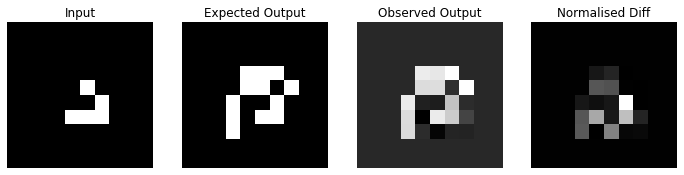

In [16]:
config_list = [{ 'sparsity': 0.1, 'op_types': ['default'] }]
m = prune_model_and_test(model, LevelPruner, config_list)
display_test(m)

### FPGM Pruner

max loss: 2.140391


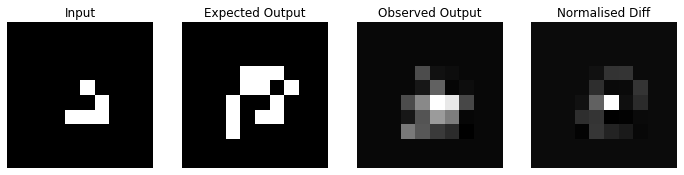

In [17]:
config_list = [{ 'sparsity': 0.1, 'op_types': ['Conv2d'] }]
m = prune_model_and_test(model, FPGMPruner, config_list)
display_test(m)

### L1 Pruner

max loss: 0.8823628


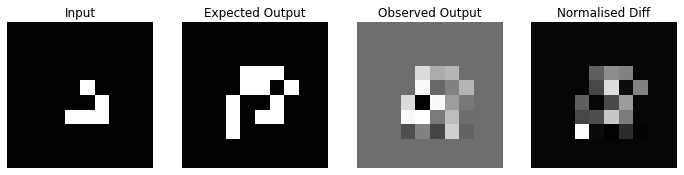

In [18]:
config_list = [{ 'sparsity': 0.1, 'op_types': ['Conv2d'] }]
m = prune_model_and_test(model, L1FilterPruner, config_list)
display_test(m)

### L2 Pruner

max loss: 1.4516169


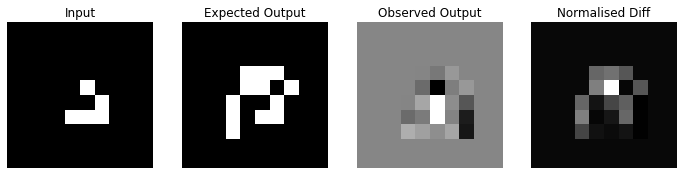

In [19]:
config_list = [{ 'sparsity': 0.1, 'op_types': ['Conv2d'] }]
m = prune_model_and_test(model, L2FilterPruner, config_list)
display_test(m)

### LotteryTicket Pruner

max loss: 2.7578222e-12


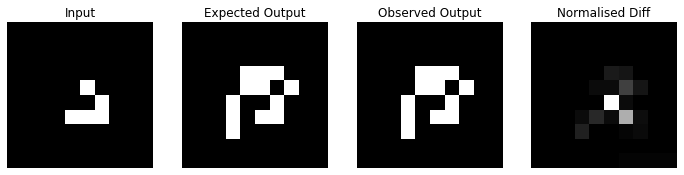

In [20]:
config_list = [{
    'prune_iterations': 50,
    'sparsity': 0.1,
    'op_types': ['default']
}]
m = prune_model_and_test(model, LotteryTicketPruner, config_list)
display_test(m)

## LMC Complexity

In [21]:
def lmc_complexity(ca, m=M, d=D):  
    inputs = torch.from_numpy(ALL_INPUTS)
    outputs = ca(inputs)
    output_counts = np.array(list(Counter(tuple(torch.reshape(o, [-1]).numpy()) for o in outputs).values()))
    output_ps = output_counts / len(inputs)
    
    H = entropy(output_ps, base=2)

    N = m ** np.product(d)
    ps = np.zeros(N)
    ps[:len(output_ps)] = output_ps
    uniform_ps = np.full(N, 1.0 / N)
    
    D = np.sum((ps - uniform_ps) ** 2)
    
    return H * D

512it [00:12, 39.52it/s]


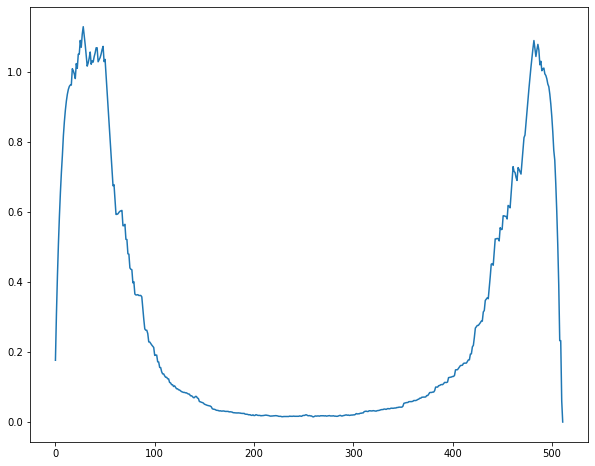

In [22]:
lmcs = [lmc_complexity(a) for a in tqdm(sample_CAs(seed=0))]
plt.plot(lmcs)